In [1]:
from sklearn import linear_model
from scipy.stats import t,laplace,norm,multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline

### Linear Gaussian Systems

In [62]:
def pltcontour(mu,sigma):
    x1,x2 = np.mgrid[-10:10:.05, -10:10:.05]
    pos = np.dstack((x1, x2))
    rv = multivariate_normal(mu,sigma)
    plt.contour(x1, x2, rv.pdf(pos))
    plt.xlim([-10,10])
    plt.ylim([-10,10])

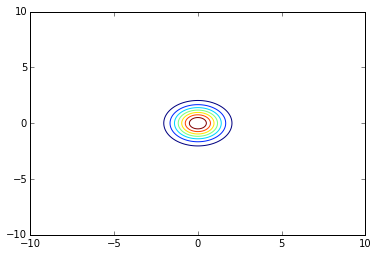

In [63]:
# assume a Gaussian prior on the true location of the airplane
mu0 = [0,0]
sigma0 = [[1, 0], [0, 1]]
pltcontour(mu0,sigma0)

[[ 0.66666667  0.        ]
 [ 0.          0.33333333]]
[[ 0.5  0. ]
 [ 0.   0.2]]
[[ 0.4         0.        ]
 [ 0.          0.14285714]]
[[ 0.33333333  0.        ]
 [ 0.          0.11111111]]
[[ 0.28571429  0.        ]
 [ 0.          0.09090909]]
[[ 0.25        0.        ]
 [ 0.          0.07692308]]
[[ 0.22222222  0.        ]
 [ 0.          0.06666667]]
[[ 0.2         0.        ]
 [ 0.          0.05882353]]


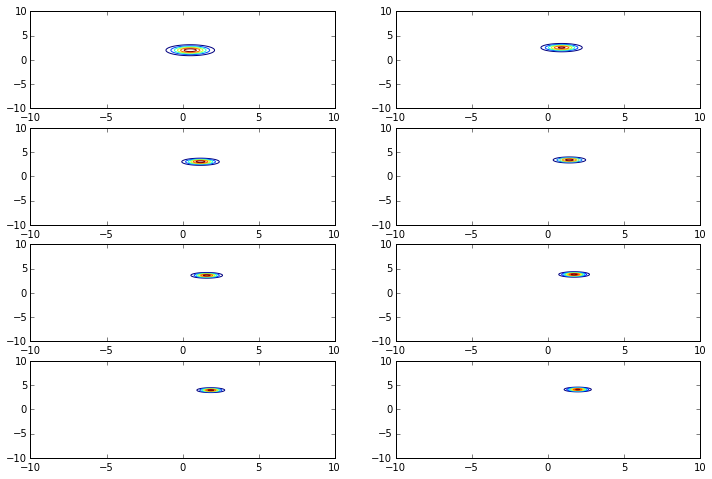

In [71]:
# observe first noisy observation
muy = mu0
sigmay = sigma0
xs = [[1,1],[1.2,0.8],[1.1,1.2],[1.2,1.3],[1,1],[1,1],[1,1],[1,1]]
sigmax = [[2,0],[0,0.5]]
# compute posterior for y
i = 1
fig = plt.figure(figsize=[12,8])
for x in xs:
    x = np.array(x)
    sigmay_post = np.linalg.inv(np.linalg.inv(sigmay) + np.linalg.inv(sigmax))
    muy_post = np.dot(sigmay,np.dot(np.linalg.inv(sigmax),x) + np.dot(np.linalg.inv(sigmay),muy))
    muy = muy_post
    sigmay = sigmay_post
    print sigmay
    plt.subplot(4,2,i)
    i = i + 1
    pltcontour(muy,sigmay)

### Ordinary Linear Regression
We use np.polyfit with order = 1 to fit a line to the 1-D data.

/Users/chandola/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


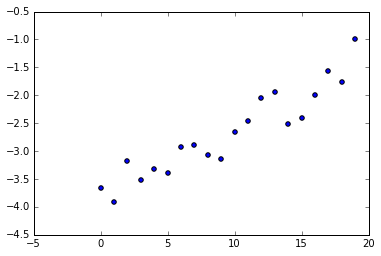

In [4]:
x = np.arange(20)
w = np.array([-3.8,0.11])
y = w[0] + w[1]*x
sigma2 = 0.1
y = y + np.random.normal(0,sqrt(sigma2),x.shape[0])

plt.scatter(x,y)


In [5]:
w = np.polyfit(x, y, 1)
print w

[ 0.12225551 -3.82735644]


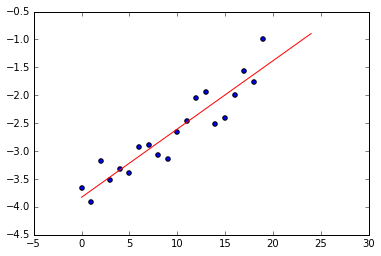

In [6]:
r_x, r_y = zip(*((i, i*w[0] + w[1]) for i in range(25)))
plt.scatter(x,y)
plt.plot(r_x, r_y, color="red")

### Impact of outliers
OLE is susceptible to outliers because of the square term in the loss function. For Bayesian regression, the issue arises because of the square term in the pdf of the Gaussian distribution. See below for alternate distributions.

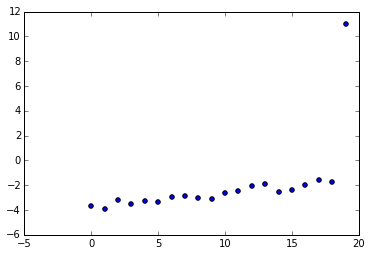

In [7]:
# adding outliers
y[19] = -3*y[0]
plt.scatter(x,y)

In [8]:
w = np.polyfit(x, y, 1)
print w


[ 0.29335605 -4.85395966]


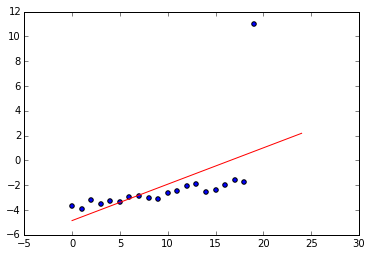

In [9]:
r_x, r_y = zip(*((i, i*w[0] + w[1]) for i in range(25)))
plt.scatter(x,y)
plt.plot(r_x, r_y, color="red")

### Using robust regression
The statsmodels package has a robust linear regression model function (rlm) which uses a different norm than (squared) for the loss function. 

In [10]:
import statsmodels.api as sm
x1 = np.transpose(np.vstack([x, np.ones(x.shape[0])]))
# Fit model and print summary
rlm_model = sm.RLM(y, x1, M=sm.robust.norms.HuberT())
w = rlm_model.fit()
w =  w.params
print w


[ 0.12053001 -3.81739969]


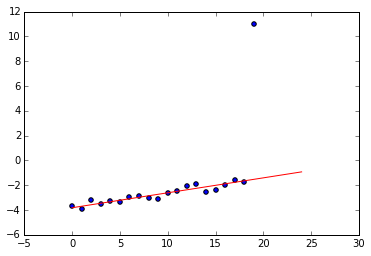

In [11]:
r_x, r_y = zip(*((i, i*w[0] + w[1]) for i in range(25)))
plt.scatter(x,y)
plt.plot(r_x, r_y, color="red")

### Handling outliers using other distributions
Below are some alternate distributions with less fat tail than Gaussian.

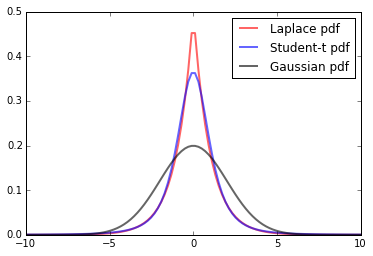

In [12]:
# comparing student-t, norm, laplace
s = np.linspace(-10,10, 100)
df = 2.74335149908
plt.plot(s, laplace.pdf(s),'r-', lw=2, alpha=0.6, label='Laplace pdf')
plt.plot(s, t.pdf(s,df),'b-', lw=2, alpha=0.6, label='Student-t pdf')
plt.plot(s, norm.pdf(s,0,2),'k-', lw=2, alpha=0.6, label='Gaussian pdf')
plt.legend()